# Clean Data

### Imports

In [124]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

# To visualize pipeline models
from sklearn import set_config
from sklearn.utils import estimator_html_repr


# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Boosted Models
from xgboost import XGBClassifier

# Permutation Importance
from sklearn.inspection import permutation_importance

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML


## Utility Function

In [125]:
def group_imputer(df, grouping_col, cols_to_impute):
    """
    Impute values in a dataframe based on averages WITHIN a given category
    :param df: Pandas DataFrame
    :param grouping_col: String, column name to group by
    :param cols_to_impute: List, column names where NaNs will be imputed
    :return: Pandas DataFrame
    """
    entries_in_group_col = df[grouping_col].unique()
    df_group_means = df.groupby(by=grouping_col)[cols_to_impute].median()

    # Loop over input df and replace/impute values
    for entry in entries_in_group_col:
        for column in cols_to_impute:
            fill_value = df_group_means.loc[entry, column]
            # fill_value = 100.01
            # df[df[grouping_col]==entry][column] = df[df[grouping_col]==entry][column].fillna(fill_value)
            # df[df[grouping_col] == entry][column].fillna(fill_value, inplace=True)
            mask = df[grouping_col] == entry
            df.loc[mask, column] = df.loc[mask, column].fillna(fill_value)

    return df

## Clean NFL Combine Data

In [126]:
combine_file = r'data\nfl_combine_1987_2020.csv'

df_raw_combine = pd.read_csv(combine_file)

df_raw_combine.head()

# Keep raw data import for reference - build copy to modify
df_combine = df_raw_combine

# Drop dummy '0' column and Wonderlic scores data
combine_cols_to_drop = ['Unnamed: 0', 'Wonderlic']
df_combine.drop(columns=combine_cols_to_drop, inplace=True)

# Clean column headers
df_combine.columns = df_combine.columns.str.lower()
df_combine.rename(columns={'college':'school'}, inplace=True)

# Clean school names
df_combine['school'] = df_combine['school'].str.strip()

# Drop years prior to 2000 (no draft data)
print(df_combine.shape)
df_combine.drop(df_combine[df_combine['year']<2000].index, inplace=True)
print('Cleaned combine size: ', df_combine.shape)
df_combine.head()

(12808, 15)
Cleaned combine size:  (8465, 15)


,year,name,school,pos,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,vert leap (in),broad jump (in),shuttle,3cone,60yd shuttle
4343,2000,Darnell Alford,Boston College,OT,76.0,334,10.50,34.00,5.58,23.0,25.0,94.0,4.98,8.48,NaN
4344,2000,Kyle Allamon,Texas Tech,TE,74.5,253,9.88,31.00,5.01,NaN,29.0,104.0,4.49,7.29,12.47
4345,2000,Rashard Anderson,Jackson State (MS),CB,74.4,206,10.00,33.00,4.59,NaN,34.0,123.0,4.15,7.18,11.72
4346,2000,Corey Atkins,South Carolina,OLB,72.4,237,9.75,31.88,4.76,21.0,31.0,112.0,4.39,7.96,11.87
4347,2000,Reggie Austin,Wake Forest,CB,69.4,175,8.50,30.00,4.46,17.0,35.0,119.0,4.14,7.03,NaN


## Import position mapping data
The "combine" dataset maps players to very specific positions (ie, "Free Safety" or "Outside Linebacker").

Map these granular positions to more standard positions. Also classify each position as "Offense" or "Defense", and indicate if the position is a "Skill" position or on the line of scrimmage.

In [127]:
df_positions = pd.read_csv('data/position_mapping.csv')
df_positions.head()

,pos,pos_group,offense_defense,line_or_skill
0,WR,WR,O,S
1,CB,CB,D,S
2,RB,RB,O,S
3,DE,DL,D,L
4,OT,OL,O,L


### Merge the draft and position mapping datasets

In [128]:
print('Granular position counts in combine dataset:')
print(df_combine['pos'].value_counts().head())

df_combine = df_combine.merge(df_positions,
                          how='left',
                          on='pos')

print('\nPosition Group counts after merging with position map:')
print(df_combine['pos_group'].value_counts())

df_combine.head()

Granular position counts in combine dataset:
WR    1095
CB     864
RB     700
DE     657
DT     647
Name: pos, dtype: int64

Position Group counts after merging with position map:
OL    1409
DL    1331
WR    1095
LB    1027
CB     864
S      701
RB     700
TE     471
QB     470
K      200
FB     175
SN      22
Name: pos_group, dtype: int64


,year,name,school,pos,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,vert leap (in),broad jump (in),shuttle,3cone,60yd shuttle,pos_group,offense_defense,line_or_skill
0,2000,Darnell Alford,Boston College,OT,76.0,334,10.50,34.00,5.58,23.0,25.0,94.0,4.98,8.48,NaN,OL,O,L
1,2000,Kyle Allamon,Texas Tech,TE,74.5,253,9.88,31.00,5.01,NaN,29.0,104.0,4.49,7.29,12.47,TE,O,S
2,2000,Rashard Anderson,Jackson State (MS),CB,74.4,206,10.00,33.00,4.59,NaN,34.0,123.0,4.15,7.18,11.72,CB,D,S
3,2000,Corey Atkins,South Carolina,OLB,72.4,237,9.75,31.88,4.76,21.0,31.0,112.0,4.39,7.96,11.87,LB,D,S
4,2000,Reggie Austin,Wake Forest,CB,69.4,175,8.50,30.00,4.46,17.0,35.0,119.0,4.14,7.03,NaN,CB,D,S


#### Visualize combine performance distributions by position

['OL', 'TE', 'CB', 'LB', 'S', 'DL', 'QB', 'RB', 'WR', 'FB']
{'WR': 'S', 'CB': 'S', 'RB': 'S', 'DL': 'L', 'OL': 'L', 'LB': 'S', 'TE': 'S', 'QB': 'S', 'S': 'S', 'FB': 'S', 'K': 'ST', 'SN': 'ST'}
['OL', 'DL', 'TE', 'CB', 'LB', 'S', 'QB', 'RB', 'WR', 'FB']
Unique Positions:  10
Index(['year', 'name', 'school', 'pos', 'height (in)', 'weight (lbs)',
       'hand size (in)', 'arm length (in)', '40 yard', 'bench press',
       'vert leap (in)', 'broad jump (in)', 'shuttle', '3cone', '60yd shuttle',
       'pos_group', 'offense_defense', 'line_or_skill'],
      dtype='object')


C:\Users\mitch\AppData\Local\Temp/ipykernel_51136/3965164478.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


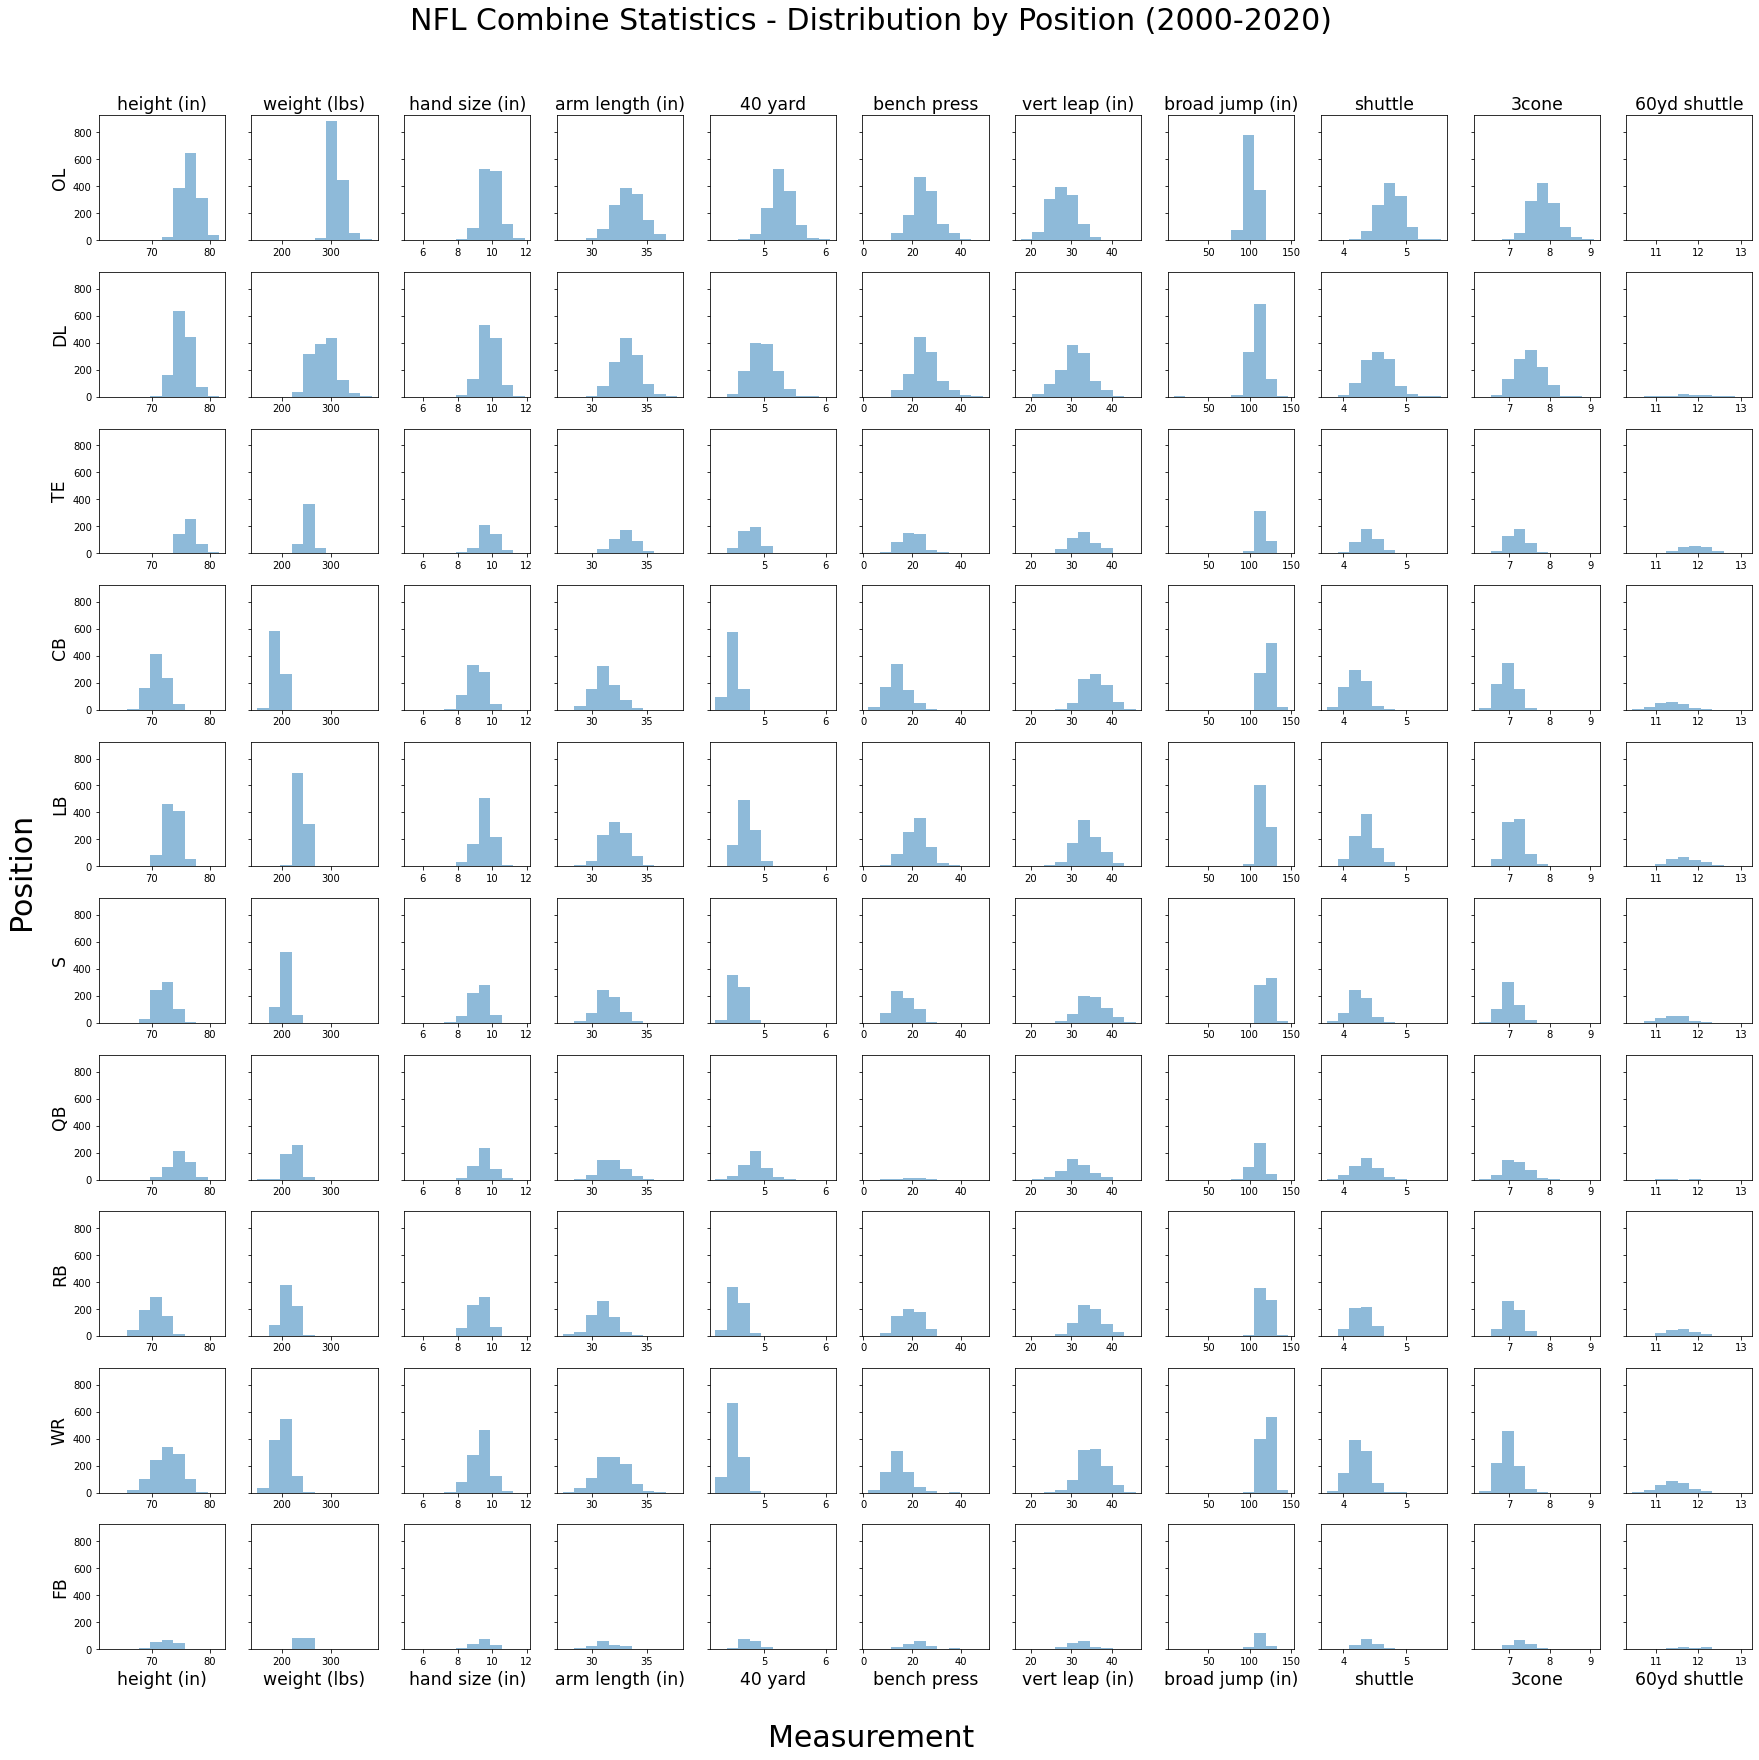

In [129]:
positions = df_combine['pos_group'].unique()

positions_to_drop = ['SN', 'K']   # Long snappers and kickers/punters

positions = [pos for pos in positions if pos not in positions_to_drop]
print(positions)

# Sort positions by L(ine)/S(kill)
sort_dict = pd.Series(df_positions['line_or_skill'].values,index=df_positions['pos_group']).to_dict()
print(sort_dict)
positions.sort(key=lambda x: sort_dict[x])
print(positions)

print('Unique Positions: ', len(positions))
print(df_combine.columns)
stat_columns = ['height (in)', 'weight (lbs)',
       'hand size (in)', 'arm length (in)', '40 yard', 'bench press',
       'vert leap (in)', 'broad jump (in)', 'shuttle', '3cone', '60yd shuttle']
num_stats = len(stat_columns)

fig, axes = plt.subplots(len(positions), num_stats,
                         sharex=False,
                         sharey=True,
                         figsize=(25,25))

fig.suptitle('NFL Combine Statistics - Distribution by Position (2000-2020)', fontsize=30)
fig.supxlabel('Measurement', fontsize=30)
fig.supylabel('Position', fontsize=30)

fig.tight_layout(rect=[0.03, 0.03, 1, .95])

# Loop over axes and data
for row, pos in enumerate(positions):
    x_positions = df_combine[df_combine['pos_group']==pos]

    for col, stat in enumerate(stat_columns):
        # Get axis
        ax = axes[row,col]
        x = x_positions[stat]
        ax.hist(x,
                range=[df_combine[stat].min(),df_combine[stat].max()],
                alpha=.5, bins=10)
        # Set Y label once per row
        if col==0:
            ax.set_ylabel(pos, fontsize='xx-large')

        # Set X label above first row and below last row
        if row == 0:
            ax.set_title(stat, fontsize='xx-large')
        if row == len(positions) - 1:
            ax.set_xlabel(stat, fontsize='xx-large')

fig.show()
fig.savefig('images/stats_by_position.png', format='png')


## Import and clean NFL Draft Data

In [130]:
draft_file = r'data\espn_draft_history_2000_2021_cleaned.csv'
df_raw_draft = pd.read_csv(draft_file)

# Keep raw data import for reference - build copy to modify
df_draft = df_raw_draft

# Clean column headers
df_draft.columns = df_draft.columns.str.lower()

# Clean school names
df_draft['school'] = df_draft['school'].str.strip()
df_draft.head()

,year,round,pk(ovr),team,name,position,school
0,2000,1,1(1),Browns,Courtney Brown,DE,Penn State
1,2000,1,2(2),Redskins,LaVar Arrington,LB,Penn State
2,2000,1,3(3),Redskins,Chris Samuels,OT,Alabama
3,2000,1,4(4),Bengals,Peter Warrick,WR,Florida State
4,2000,1,5(5),Ravens,Jamal Lewis,RB,Tennessee


### Are there duplicated names?

In [131]:
df_combine['name'].value_counts(sort='descending').head(10)

Brandon Williams    5
Chris Brown         5
Brian Allen         4
Mike Williams       4
Chris Jones         4
Michael Bennett     3
Josh Harris         3
Travis Wilson       3
Steve Smith         3
Andre Smith         3
Name: name, dtype: int64

### Answer: Yes

So we cannot simply join the 2 datasets on player 'name' columns. Need to also join on
college and year.


## Do college names match in both datasets?

In [132]:
draft_school = pd.DataFrame(df_draft['school'].unique()).rename(columns={0:'school'})
draft_school['source'] = 'draft'
combine_school = pd.DataFrame(df_combine['school'].unique()).rename(columns={0:'school'})
combine_school['source'] = 'combine'
print(type(combine_school))
print(combine_school.head())

schools = draft_school.merge(combine_school, on='school', how='outer',
                             suffixes=['_draft', '_combine']).sort_values(by='school')

# List all cases with mismatches
na_mask = schools.isna().any(axis=1)
schools[na_mask].head(10)

<class 'pandas.core.frame.DataFrame'>
               school   source
0      Boston College  combine
1          Texas Tech  combine
2  Jackson State (MS)  combine
3      South Carolina  combine
4         Wake Forest  combine


,school,source_draft,source_combine
202,Abilene Christian,draft,NaN
381,Abilene Christian (TX),NaN,combine
445,Adams State (CO),NaN,combine
345,Alabama-Birmingham,NaN,combine
200,Albany,draft,NaN
388,Albany (NY),NaN,combine
412,Alcorn State (MS),NaN,combine
133,Appalachian State,draft,NaN
336,Appalachian State (NC),NaN,combine
255,Ashland,draft,NaN


### So we see that the 'combine' dataset frequently has the state appended to the school name;
Ex: "Abilene Christian (TX)". Remove these from school names, with the exception of "Miami (OH).

In [133]:
df_combine['school'] = df_combine['school'].str.replace('Miami (OH)', 'Miami - OH')

print(df_combine['school'].head())
regex_replace_parens = r'\([^)]*[a-zA-Z][^)]*\)'
df_combine['school'] = df_combine['school'].str.replace(regex_replace_parens,
                                                        '', regex=True)

df_combine['school'].head()

0        Boston College
1            Texas Tech
2    Jackson State (MS)
3        South Carolina
4           Wake Forest
Name: school, dtype: object


C:\Users\mitch\AppData\Local\Temp/ipykernel_51136/172860408.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_combine['school'] = df_combine['school'].str.replace('Miami (OH)', 'Miami - OH')


0    Boston College
1        Texas Tech
2    Jackson State 
3    South Carolina
4       Wake Forest
Name: school, dtype: object

## Standardize player names between datasets
Player names in the "Draft" dataset include suffixes including "Jr., II, III, IV", but these are NOT included in the "combine" dataset.

Standardize player names between datasets by removing these values from the "Draft" dataset.

In [134]:
regex_suffixes_to_remove = r'Jr\.$|III$|IIII$|IV$|, Jr.$'
df_draft['name'] = df_draft['name'].str.replace(regex_suffixes_to_remove,
                                                '', regex=True)

### Merge the Draft and NFL Combine datasets

In [135]:
df_merged = df_combine.merge(df_draft, how='left',
                             on=['name', 'school', 'year'])

df_merged.head()

# df_merged.to_clipboard()

,year,name,school,pos,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,...,shuttle,3cone,60yd shuttle,pos_group,offense_defense,line_or_skill,round,pk(ovr),team,position
0,2000,Darnell Alford,Boston College,OT,76.0,334,10.50,34.00,5.58,23.0,...,4.98,8.48,NaN,OL,O,L,6.0,22(188),Chiefs,OT
1,2000,Kyle Allamon,Texas Tech,TE,74.5,253,9.88,31.00,5.01,NaN,...,4.49,7.29,12.47,TE,O,S,NaN,NaN,NaN,NaN
2,2000,Rashard Anderson,Jackson State,CB,74.4,206,10.00,33.00,4.59,NaN,...,4.15,7.18,11.72,CB,D,S,NaN,NaN,NaN,NaN
3,2000,Corey Atkins,South Carolina,OLB,72.4,237,9.75,31.88,4.76,21.0,...,4.39,7.96,11.87,LB,D,S,NaN,NaN,NaN,NaN
4,2000,Reggie Austin,Wake Forest,CB,69.4,175,8.50,30.00,4.46,17.0,...,4.14,7.03,NaN,CB,D,S,4.0,31(125),Bears,DB


## Investigate merged data

In [136]:
df_merged.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8464
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             8465 non-null   int64  
 1   name             8465 non-null   object 
 2   school           8462 non-null   object 
 3   pos              8465 non-null   object 
 4   height (in)      8465 non-null   float64
 5   weight (lbs)     8465 non-null   int64  
 6   hand size (in)   7639 non-null   float64
 7   arm length (in)  7638 non-null   float64
 8   40 yard          7922 non-null   float64
 9   bench press      6603 non-null   float64
 10  vert leap (in)   7503 non-null   float64
 11  broad jump (in)  7400 non-null   float64
 12  shuttle          6929 non-null   float64
 13  3cone            6827 non-null   float64
 14  60yd shuttle     1370 non-null   float64
 15  pos_group        8465 non-null   object 
 16  offense_defense  8465 non-null   object 
 17  line_or_skill 

## Data Cleaning:
* Very few 60-yard shuttle records; drop column
* Set the "round" value for all undrafted players to '8'
* Drop kickers, long snappers, QBs and Fullbacks (too few, draft status not driven by stats)

In [137]:
# Drop 60yd shuttle (too few data points), duplicative columns related to
# player position, and things like year and team name
merged_cols_to_drop = ['year', 'name', 'school', 'pos',
                       '60yd shuttle',
                       'pk(ovr)', 'team', 'position']

try:
    df_merged.drop(columns=merged_cols_to_drop, inplace=True)
except:
    print('Issue dropping columns')


# overwite blank 'round' values with '8' (will indicate undrafted)
df_merged['round'].fillna(8, inplace=True)
# df_merged.dropna(inplace=True)

### Below: Test to condense draft 'round' into high/low/undrafted
# df_merged['round'].loc[(df_merged['round']>=1) & (df_merged['round']<4)] = 1
# df_merged['round'].loc[(df_merged['round']>=4) & (df_merged['round']<8)] = 2
# df_merged['round'].fillna(3, inplace=True)
# print(df_merged['round'].value_counts())

print('\n Remaining Columns')
print(df_merged.columns)

positions_to_drop = ['SN', 'K', 'QB', 'FB']
positions_mask = \
    df_merged[df_merged['pos_group'].isin(positions_to_drop)].index

# print(positions_mask)

# print(df_merged.shape)
df_merged.drop(positions_mask, inplace=True)
# print(df_merged.head())


 Remaining Columns
Index(['height (in)', 'weight (lbs)', 'hand size (in)', 'arm length (in)',
       '40 yard', 'bench press', 'vert leap (in)', 'broad jump (in)',
       'shuttle', '3cone', 'pos_group', 'offense_defense', 'line_or_skill',
       'round'],
      dtype='object')


### Drop players with sparse combine statistics

In [138]:
metrics_cols = ['height (in)', 'weight (lbs)', 'hand size (in)', 'arm length (in)',
       '40 yard', 'bench press', 'vert leap (in)', 'broad jump (in)',
       'shuttle', '3cone']

# See count of records by number of missing metrics values
# 10 total metrics values, drop if they don't have at least 8
print('\n Missing metrics per row')
print(df_merged[metrics_cols].isna().sum(axis=1).value_counts())
df_merged.dropna(axis=0, thresh=7,
                 subset=metrics_cols, inplace=True)
print('\nRemaining missing metrics by row')
print(df_merged[metrics_cols].isna().sum(axis=1).value_counts())

df_merged.head(10)


 Missing metrics per row
0    4946
1     846
2     786
3     311
4     280
5     155
6     120
8      83
7      71
dtype: int64

Remaining missing metrics by row
0    4946
1     846
2     786
3     311
dtype: int64


,height (in),weight (lbs),hand size (in),arm length (in),40 yard,bench press,vert leap (in),broad jump (in),shuttle,3cone,pos_group,offense_defense,line_or_skill,round
0,76.0,334,10.50,34.00,5.58,23.0,25.0,94.0,4.98,8.48,OL,O,L,6.0
1,74.5,253,9.88,31.00,5.01,NaN,29.0,104.0,4.49,7.29,TE,O,S,8.0
2,74.4,206,10.00,33.00,4.59,NaN,34.0,123.0,4.15,7.18,CB,D,S,8.0
3,72.4,237,9.75,31.88,4.76,21.0,31.0,112.0,4.39,7.96,LB,D,S,8.0
4,69.4,175,8.50,30.00,4.46,17.0,35.0,119.0,4.14,7.03,CB,D,S,4.0
5,77.9,312,9.25,32.75,5.36,20.0,28.0,96.0,4.73,7.72,OL,O,L,7.0
6,71.6,208,9.50,32.00,4.63,10.0,35.0,114.0,4.32,6.92,S,D,S,7.0
7,69.9,199,10.00,31.13,4.48,16.0,37.5,116.0,4.04,6.81,CB,D,S,4.0
8,73.0,192,NaN,NaN,4.43,NaN,38.5,124.0,3.99,6.70,CB,D,S,2.0
10,71.0,178,NaN,NaN,4.50,NaN,34.5,122.0,4.20,6.87,CB,D,S,5.0


In [139]:
df_merged.columns


Index(['height (in)', 'weight (lbs)', 'hand size (in)', 'arm length (in)',
       '40 yard', 'bench press', 'vert leap (in)', 'broad jump (in)',
       'shuttle', '3cone', 'pos_group', 'offense_defense', 'line_or_skill',
       'round'],
      dtype='object')

## Impute missing values based on average of players with same position


In [140]:
# print(df_merged.head(10))

df_merged = group_imputer(
    df=df_merged,
    grouping_col='pos_group',
    cols_to_impute=metrics_cols)

# print('\n')
# print(df_merged.head(10))

## Drop either "line" or "skill" players from dataset

In [141]:
drop_skill_or_line = 'S'    # 'S' for skill or 'L' for line
drop_index = df_merged[df_merged['line_or_skill']==drop_skill_or_line].index
df_for_models = df_merged.drop(drop_index)
df_for_models.head(5)
df_for_models['round'].count()

2458

### Is the dataset imbalanced?

8.0    1338
1.0     186
7.0     169
4.0     162
3.0     160
5.0     153
6.0     150
2.0     140
Name: round, dtype: int64


<AxesSubplot:>

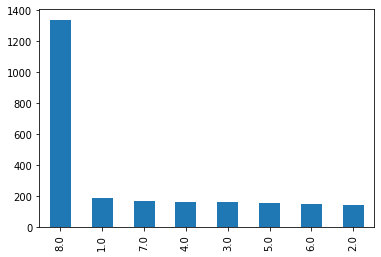

In [142]:
print(df_for_models['round'].value_counts())
df_for_models['round'].value_counts().plot.bar()

### Yep
Undersample values of the 'undrafted' (round=8) players.

In [143]:
# Number of undrafted/round=8
undrafted_count = df_for_models['round'][df_for_models['round']==8].count()
print(undrafted_count)
extra_undrafted_to_drop = \
    df_for_models[df_for_models['round']==8].sample(n=undrafted_count-200,
                                        replace=False,
                                        random_state=42).index

print('Undrafted to drop: ', extra_undrafted_to_drop)
print(extra_undrafted_to_drop.size)
df_for_models.drop(index=extra_undrafted_to_drop, inplace=True)
df_for_models['round'].value_counts()

1338
Undrafted to drop:  Int64Index([5467, 6184, 6195, 8056, 1942, 8220, 6253, 5410, 8031, 5156,
            ...
            6140, 7914, 4572, 2649, 7848, 1975, 1072, 3526, 4754, 8345],
           dtype='int64', length=1138)
1138


8.0    200
1.0    186
7.0    169
4.0    162
3.0    160
5.0    153
6.0    150
2.0    140
Name: round, dtype: int64

## Begin Modeling

Setup sklearn tools to visualize pipelines

In [144]:
set_config(display='diagram')

### Split data

In [145]:
target = 'round'
X = df_for_models.drop(columns=target)
y = df_for_models[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=21)

print(f'X_train shape: {X_train.shape} X_test shape: {X_test.shape}')

X_train shape: (1056, 13) X_test shape: (264, 13)


## Baseline Accuracy

In [146]:
baseline = y.value_counts(normalize=True).max()
baseline


0.15151515151515152

## Build Decision Tree Classifier Model/Pipeline

Decision Tree Training Accuracy 1.0
Decision Tree Validation Accuracy 0.14772727272727273


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['pos_group', 'offense_defense',
                                      'line_or_skill'],
                                mapping=[{'col': 'pos_group',
                                          'data_type': dtype('O'),
                                          'mapping': DL     1
OL     2
NaN   -2
dtype: int64},
                                         {'col': 'offense_defense',
                                          'data_type': dtype('O'),
                                          'mapping': D      1
O      2
NaN   -2
dtype: int64},
                                         {'col': 'line_or_skill',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
NaN   -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

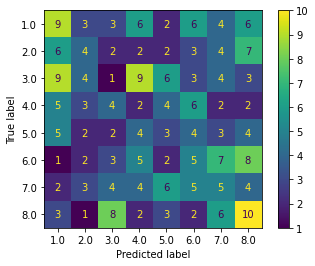

In [147]:
# Base Model
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)

model_dt.fit(X_train, y_train)

print('Decision Tree Training Accuracy', model_dt.score(X_train, y_train))
print('Decision Tree Validation Accuracy', model_dt.score(X_test, y_test))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=model_dt.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=model_dt.classes_)
display.plot()

# Export HTML of pipeline model
with open('pipe_html/model_dt.html', 'w') as f:
    f.write(estimator_html_repr(model_dt))

model_dt


## Build Tuned Random Forest Model/Pipeline

In [148]:
# Base Model
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

# Parameter distributions for hyperparameter tuning
# Note double underscores __ in keys below
param_distributions = {
    'randomforestclassifier__max_depth': range(3,50,5),
    'randomforestclassifier__n_estimators': range(10,2000, 10),
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__warm_start': [True, False]
}

tuned_rf = RandomizedSearchCV(
    model_rf,
    param_distributions=param_distributions,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=6
)

model_rf.fit(X_train, y_train)
tuned_rf.fit(X_train, y_train)

# Export HTML of pipeline model
with open('pipe_html/tuned_rf.html', 'w') as f:
    f.write(estimator_html_repr(tuned_rf))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=tuned_rf.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=tuned_rf.classes_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


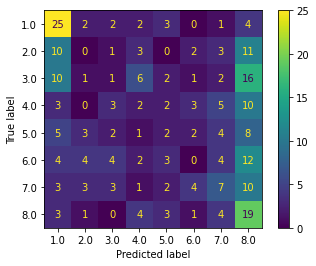

In [149]:
# Save image for blog
# display.figure_.savefig(r'images/tuned_rf_conf_matrix.png')
display.plot()

### Evaluate Tuned Random Forest Model/Pipeline

In [150]:
print('Default RF training score: ', model_rf.score(X_test, y_test))
print('Tuned RF training best score: ', tuned_rf.best_score_)
print('Tuned RF best parameters: ', tuned_rf.best_params_)
print('Tuned RF test score: ', tuned_rf.score(X_test, y_test))

Default RF training score:  0.17424242424242425
Tuned RF training best score:  0.20639810426540284
Tuned RF best parameters:  {'randomforestclassifier__warm_start': False, 'randomforestclassifier__n_estimators': 140, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__bootstrap': True}
Tuned RF test score:  0.21212121212121213


### Get Permutation importances for model

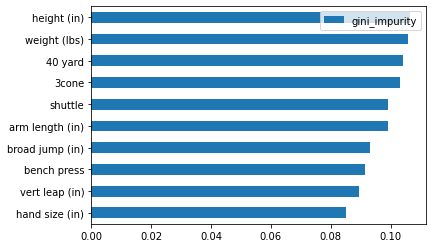

In [151]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_

gini_imp = pd.DataFrame(data=importances, index=X_test.columns, columns=['gini_impurity']).sort_values(by='gini_impurity')

gini_imp.tail(10).plot(kind='barh');



## Build XGBoost Model/Pipeline

[19:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "loss" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Py\nfl_combine_draft\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


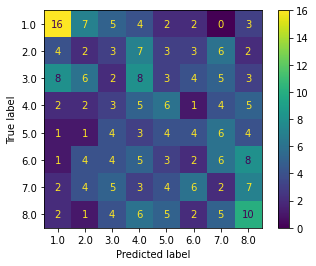

In [152]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        loss='deviance',
        # learning_rate=0.1,
        n_estimators=500,
        subsample=1,
        max_depth=4,
        random_state=42
    )
)

model_xgb.fit(X_train, y_train)

# Export HTML of pipeline model
with open('pipe_html/model_xgb.html', 'w') as f:
    f.write(estimator_html_repr(model_xgb))

model_xgb

conf_matrix = confusion_matrix(y_true=y_test, y_pred=model_xgb.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=model_xgb.classes_)
display.plot()

### Evaluate XGBoost Model/Pipeline

In [153]:
print('XGBoost Forest Training Accuracy', model_xgb.score(X_train, y_train))
print('XGBoost Forest Validation Accuracy', model_xgb.score(X_test, y_test))


XGBoost Forest Training Accuracy 1.0
XGBoost Forest Validation Accuracy 0.16287878787878787


## Build Ridge Classifier Model/Pipeline

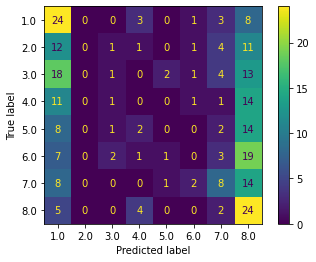

In [154]:
model_ridge = make_pipeline(
    OneHotEncoder(),
    RidgeClassifierCV(cv=5,
                      alphas=[.1,1.0,10.0])
)

model_ridge.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=model_ridge.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=model_ridge.classes_)
display.plot()

### Evaluate Ridge Classifier Model/Pipeline

In [155]:
print('Ridge Classifier Training Accuracy', model_ridge.score(X_train, y_train))
print('Ridge Classifier Validation Accuracy', model_ridge.score(X_test, y_test))


Ridge Classifier Training Accuracy 0.23863636363636365
Ridge Classifier Validation Accuracy 0.2159090909090909


### Build Tuned Ridge Classifier Model/Pipeline

In [156]:
# Base Model
model_ridgecv = make_pipeline(
    OneHotEncoder(),
    RidgeClassifierCV(alphas=(.01, .1, 1.0, 10.0, 50.0))
)

# Parameter distributions for hyperparameter tuning
# Note double underscores __ in keys below
param_distributions = {
    'ridgeclassifiercv__cv': range(2, 10),
    'ridgeclassifiercv__fit_intercept': [True, False],
    'ridgeclassifiercv__class_weight': ['balanced', None]
}

tuned_ridge = RandomizedSearchCV(
    model_ridgecv,
    param_distributions=param_distributions,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=6
)

model_ridgecv.fit(X_train, y_train)
tuned_ridge.fit(X_train, y_train)

print('Tuned Ridge Classifier Training Accuracy', tuned_ridge.score(X_train, y_train))
print('Tuned Ridge Classifier Validation Accuracy', tuned_ridge.score(X_test, y_test))
print('Tuned Ridge Classifer best parameters: ', tuned_ridge.best_params_)
tuned_ridge

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Tuned Ridge Classifier Training Accuracy 0.24526515151515152
Tuned Ridge Classifier Validation Accuracy 0.2196969696969697
Tuned Ridge Classifer best parameters:  {'ridgeclassifiercv__fit_intercept': False, 'ridgeclassifiercv__cv': 7, 'ridgeclassifiercv__class_weight': None}


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(cols=['pos_group',
                                                                  'offense_defense',
                                                                  'line_or_skill'])),
                                             ('ridgeclassifiercv',
                                              RidgeClassifierCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+01])))]),
                   n_iter=25, n_jobs=6,
                   param_distributions={'ridgeclassifiercv__class_weight': ['balanced',
                                                                            None],
                                        'ridgeclassifiercv__cv': range(2, 10),
                                        'ridgeclassifiercv__fit_intercept': [True,
                                                                             False]},
                   verbose=1)